In [ ]:
import sys
import xarray as xr
sys.path.append(r'C:\Users\everett\Documents\GitHub\camus_to')


data_file = r"C:\Users\everett\Documents\GitHub\camus_to\data\clean\camus_to.nc"

station_id = "HY006"

In [32]:
from pyswmm import Simulation, Nodes
nodes = ["node1","node2"]
res = {node:[] for node in nodes}
dti = []

PARAM_MAPPING = {"discharge":"total_inflow","stage":"depth"}

model_file = r"models/HY006/HY006.inp"
with Simulation(model_file) as sim:
    for step in sim:
        dti.append(sim.current_time)
        for node in nodes:
            res[node].append(getattr(Nodes(sim)[node],PARAM_MAPPING["discharge"]))



<Axes: >

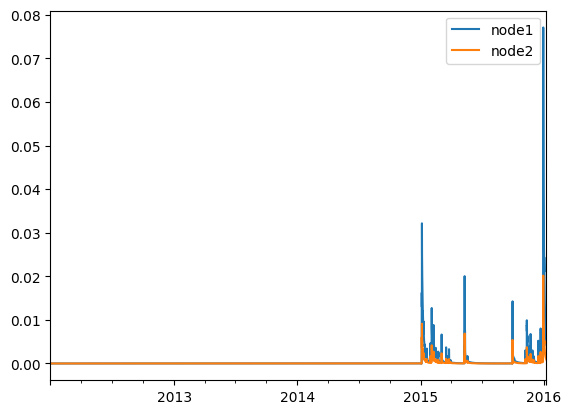

In [36]:
df = pd.DataFrame(index=dti, data=res)
df.plot()

In [23]:
from swmmio import Model

Model(model_file).nodes().index.tolist()

['node0',
 'node1',
 'node2',
 'node3',
 'node4',
 'node5',
 'node6',
 'node7',
 'node8',
 'node9',
 'node10',
 'node11',
 'node12',
 'node13',
 'node14',
 'node15',
 'node16',
 'node17',
 'node18',
 'node19',
 'node20',
 'node21',
 'node22',
 'node23',
 'node24',
 'node25',
 'node26',
 'node27',
 'node28',
 'node29',
 'node30',
 'node31',
 'node32',
 'node33',
 'node34',
 'node35',
 'node36',
 'node37',
 'node38',
 'node39',
 'node40',
 'node41',
 'node42',
 'node43',
 'node44',
 'node45',
 'node46',
 'node47',
 'node48',
 'node49',
 'node50',
 'node51',
 'node52',
 'node53',
 'node54',
 'node55',
 'node56',
 'node57',
 'node58',
 'node59',
 'node60',
 'node61',
 'node62',
 'node63',
 'node64',
 'node65',
 'node66',
 'node67',
 'node68',
 'node69',
 'node70',
 'node71',
 'node72',
 'node73',
 'node74',
 'node75',
 'node76',
 'node77',
 'node78',
 'node79',
 'node80',
 'node81',
 'node82',
 'node83',
 'node84',
 'node85',
 'node86',
 'node87',
 'node88',
 'node89',
 'node90',
 'node91'

In [18]:
from swmmio import Model
mdl = Model("models/HY006/HY006.inp")

from utils.swmmutils import 
mdl.inp.options.loc["START_DATE"].Value

'01/01/2012'

In [19]:
import pandas as pd
tgt = pd.read_pickle("models/HY006/targets.pkl")
tgt_stations = tgt.columns.get_level_values('station').unique().to_list()
tgt_stations


def _validate_target_data(tgt:pd.DataFrame, model:Model) -> bool:
    model_nodes = model.nodes().index.tolist()
    tgt_stations = tgt.columns.get_level_values('station').unique().to_list()
    
    missing_stations = [station for station in tgt_stations if station not in model_nodes]
    if missing_stations:
        raise ValueError(f"Missing stations in model: {missing_stations}")

    tgt_start_date, tgt_end_date = tgt.index.min(), tgt.index.max()
    mdl_start_date, mdl_end_date = model.start_date, model.end_date




['HY006']

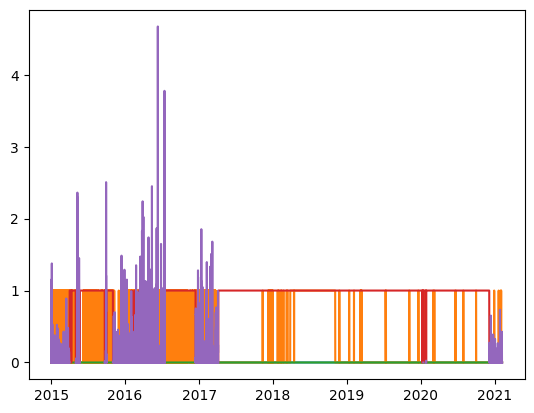

In [70]:
plt.plot(df.isna())
plt.plot(df["precipitation"])

In [56]:
import pandas as pd
df

,stage,discharge,temperature,precipitation
station,HY006,HY006,HY006,HY006
time,,,,
2015-01-01 00:15:00,0.252772,0.010861,-7.433333,0.000000
2015-01-01 00:30:00,0.254771,0.010996,-7.408333,0.000000
2015-01-01 00:45:00,0.256771,0.011030,-7.383333,0.000000
2015-01-01 01:00:00,0.259771,0.011064,-7.358333,0.000000
2015-01-01 01:15:00,0.261771,0.010928,-7.416667,0.095586
...,...,...,...,...
2021-02-05 18:00:00,0.275583,0.009178,-7.220000,0.000000
2021-02-05 18:15:00,0.275583,0.009114,-7.295000,0.000000
